# <span style='color:Black'> **Verifiable Principal Components Analysis**  </span> 


The Principal Component Analysis (PCA) method is an unsupervised learning algorithm that aims to reduce the dimensionality of a dataset consisting of a large number of interrelated variables, while at the same time preserving as much of the variation present in the original dataset as possible. This is achieved by transforming to a new set of variables, the principal components (PC), which are uncorrelated and are ordered in such a way that the first ones retain most of the variation present in all the original variables. More formally, with PCA, given 
$n$ observations of $p$ variables, it seeks the possibility of adequately representing this information with a smaller number of variables, constructed as linear combinations of the original variables.

Below, we provide a brief review of the implementation of a Principal Component Analysis (PCA) in Python, which we will then convert to Cairo to transform it into a verifiable ZKML (Principal Component Analysis), using the Orion library. This provides an opportunity to become familiar with the main functions and operators that the framework offers for the implementation of PCA.

### <span style='color:Black'> **Used DataSet**  </span>

For the purposes of this tutorial, we will use the iris dataset from sklearn.datasets.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

In [2]:
# Cargar datos de Iris
data = load_iris()
X = data['data']

y = data['target']

For the purposes of this tutorial, we will not take into account the total number of records in the original dataset. In this sense, we will only focus on the first 105 individuals and the first 3 variables, in order to have comparable results between the python and cairo implementations, taking into consideration the same number of iterations in both programs to achieve orthogonality between the components at the computational level. Therefore, we will have the total number of individuals of the species versicolor and virginica, partially the individuals of the species setosa and with the exclusion of the variable petal width.

In [3]:
X, y = X[:105,0:3], y[:105]

Before applying PCA, it is important to standardize the data. This ensures that each feature has an equal weight in the calculation of principal components.

In [4]:
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
X_std = (X - mu)/sigma

We print the first 20 rows

In [5]:
X_std[0:20,:]

array([[-0.62902748,  0.86993347, -1.04142584],
       [-0.93199944, -0.19965686, -1.04142584],
       [-1.23497139,  0.22817927, -1.10670925],
       [-1.38645737,  0.0142612 , -0.97614243],
       [-0.78051346,  1.08385154, -1.04142584],
       [-0.17456955,  1.72560573, -0.84557561],
       [-1.38645737,  0.6560154 , -1.04142584],
       [-0.78051346,  0.6560154 , -0.97614243],
       [-1.68942932, -0.41357493, -1.04142584],
       [-0.93199944,  0.0142612 , -0.97614243],
       [-0.17456955,  1.2977696 , -0.97614243],
       [-1.08348542,  0.6560154 , -0.91085902],
       [-1.08348542, -0.19965686, -1.04142584],
       [-1.8409153 , -0.19965686, -1.23727607],
       [ 0.43137435,  1.9395238 , -1.17199266],
       [ 0.27988838,  2.79519606, -0.97614243],
       [-0.17456955,  1.72560573, -1.10670925],
       [-0.62902748,  0.86993347, -1.04142584],
       [ 0.27988838,  1.51168767, -0.84557561],
       [-0.62902748,  1.51168767, -0.97614243]])

### <span style='color:Black'> **Implementation of the Jacobi algorithm**  </span>

The Jacobi algorithm is an iterative method for finding the eigenvalues and eigenvectors of a symmetric matrix, which in our case is the correlation matrix over $\mathbf{X_{std}}$. With this method, the aim is to identify pairs of elements off the main diagonal of the matrix and "rotate" them to zero using orthogonal transformations. The idea is that, after enough rotations, the matrix will converge to a diagonal matrix whose diagonal elements will be the eigenvalues of the original matrix. The eigenvectors, on the other hand, are constructed from the rotation matrices applied during the process.

In [6]:
def extract_diagonal(matrix):
    return [matrix[i][i] for i in range(len(matrix))]

In [7]:
def find_max_off_diag(A):
    n = A.shape[0]
    p, q = 0, 1
    max_val = abs(A[p, q])
    for i in range(n-1):
        for j in range(i+1, n):
            if abs(A[i, j]) > max_val:
                max_val = abs(A[i, j])
                p, q = i, j
    return p, q

def jacobi_eigensystem(A, tol=1e-2, max_iter=500): 
    if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix")
    
    n = A.shape[0]
    V = np.eye(n)

    for _ in range(max_iter):
        p, q = find_max_off_diag(A)
        
        if abs(A[p, q]) < tol:
            break
        
        if A[p, p] == A[q, q]:
            theta = math.pi/4
        else:
            theta = 0.5 * math.atan(2 * A[p, q] / (A[p, p] - A[q, q]))
        
        J = np.eye(n)
        J[p, p], J[q, q] = math.cos(theta), math.cos(theta)
        J[p, q], J[q, p] = math.sin(theta), -math.sin(theta)
        
        A = np.matmul(np.matmul(J.T,A),J)
        V = np.matmul(V,J)

    return extract_diagonal(A), V

### <span style='color:Black'> **Correlation Matrix**  </span>

At this point, we determine the correlation matrix, based on the calculations of the variance and covariance matrix for **$\mathbf{X_{std}}$** :

We compute the covariance matrix

 $\mathbf{S}$ = $\mathbf{X}^{T}$ $\mathbf{X}$ $/\mathbf{n-1}$ 

Then, we determine the correlation matrix :

$\mathbf{r}$  =  $\mathbf{Cov(X,Y)}$ $/\mathbf{S_{X} S_{Y}}$,

where $\mathbf{S_{X} S_{Y}}$ are the standard deviations of X and Y respectively. 

In [8]:
n = (X_std.shape[0]-1) 
cov_matrix = np.dot(X_std.T,X_std)/n 
stddevs = np.sqrt(extract_diagonal(cov_matrix))

In [9]:
cov_matrix

array([[ 1.00961538, -0.20656485,  0.83469099],
       [-0.20656485,  1.00961538, -0.57369635],
       [ 0.83469099, -0.57369635,  1.00961538]])

In [10]:
corr_matrix = cov_matrix / np.matmul(stddevs.reshape(-1, 1),stddevs.reshape(1, -1))

In [11]:
corr_matrix

array([[ 1.        , -0.20459756,  0.82674155],
       [-0.20459756,  1.        , -0.56823258],
       [ 0.82674155, -0.56823258,  1.        ]])

In [12]:
evalu, evec = jacobi_eigensystem(corr_matrix)

At this point, we have the eigenvalues and eigenvectors associated with the correlation matrix. Now, we sort the eigenvalues in decreasing order, as the largest of these will be associated with the component that explains the most variability in the data. Consequently, the principal components will be sorted in the same order as the eigenvalues and eigenvectors.

In [13]:
idx = np.argsort(evalu)[::-1]
evec = evec[:,idx]
evalu = np.sort(evalu)[::-1]

In [14]:
evalu, evec

(array([2.10545934, 0.81005256, 0.0844881 ]),
 array([[-0.58699831,  0.55819468, -0.58638867],
        [ 0.45714577,  0.82631669,  0.32896575],
        [-0.66816968,  0.07496276,  0.74022284]]))

### <span style='color:Black'> **Loadings PCA**  </span>

Once the aforementioned order is established, we find the loadings which are represented by the discovered eigenvectors (evec). These loadings represent the coefficients of each variable in each of the principal components.

In [15]:
loadings = pd.DataFrame(evec,columns=['PC1','PC2','PC3'], index = data['feature_names'][:3])
loadings

,PC1,PC2,PC3
sepal length (cm),-0.586998,0.558195,-0.586389
sepal width (cm),0.457146,0.826317,0.328966
petal length (cm),-0.668170,0.074963,0.740223


### <span style='color:Black'> **New axis, Principal Components**  </span>

Next, we identify the new axes or principal components, which are obtained as a linear combination of the standardized original variables.

$\mathbf{PC_{i}}$ =  $\mathbf{a_{i1}X_1}   +  \mathbf{a_{i2}X_2}  +  \mathbf{...}  +  \mathbf{a_{in}X_n}$,

Where,

$\mathbf{X_1}, \mathbf{X_2}, \mathbf{...} + \mathbf{X_n}$  are the standardized original variables.

$\mathbf{a_{i1}}, \mathbf{a_{i2}}, \mathbf{...} + \mathbf{a_{in}}$ are the coefficients or loadings of the $\mathbf{i-th}$ eigenvector.

In [16]:
principalDf = pd.DataFrame(np.dot(X_std,loadings))
principalDf.columns = ["principal component {}".format(i+1) for i in range(principalDf.shape[1])]
principalDf

,principal component 1,principal component 2,principal component 3
0,1.462774,0.289653,-0.115854
1,1.151659,-0.763285,-0.290054
2,1.568707,-0.583768,-0.019975
3,1.472596,-0.835303,0.095131
4,1.649487,0.381858,0.043347
...,...,...,...
100,-1.806412,1.175944,0.900363
101,-1.555969,-0.351478,0.487362
102,-2.767543,1.317228,-0.069714
103,-2.023098,0.449313,0.425579


Next, we validate the orthogonality between the principal components, as we observe the lack of correlation between these new variables (Principal Components).

In [17]:
n = principalDf.shape[0] - 1
cov_new = np.dot(np.array(principalDf).T,np.array(principalDf))/n 
stddevs = np.sqrt(extract_diagonal(cov_new))
corr_new = cov_new / np.matmul(stddevs.reshape(-1, 1),stddevs.reshape(1, -1))

In [18]:
corr_new

array([[ 1.        , -0.002632  , -0.01975951],
       [-0.002632  ,  1.        ,  0.0200618 ],
       [-0.01975951,  0.0200618 ,  1.        ]])

In [19]:
new_corr = round(abs(pd.DataFrame(corr_new)))
new_corr

,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


The implementation of Jacobi in Python is carried out considering 500 iterations, in order to optimize its implementation at the Cairo level. That is why rounding is applied when checking for orthogonality.

### <span style='color:Black'> **Selection of the number of components to be retained**  </span>

Each principal component accounts for a proportion of the total variance, and such proportion can be determined by the ratio of each eigenvalue to the total sum of all eigenvalues. Thus, the percentage of variance explained by the i-th component is given by:

$\frac{\lambda_i}{\sum_{j=1}^{p} \lambda_j}$

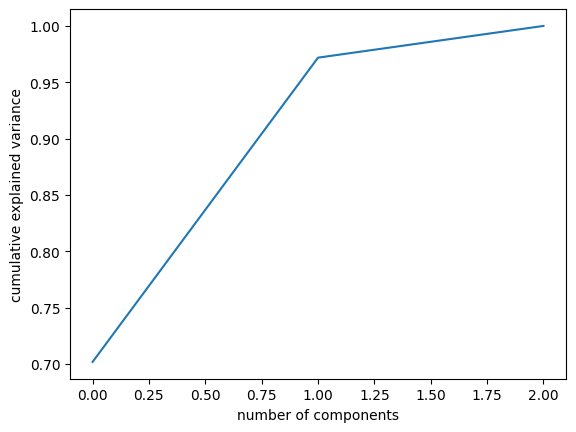

In [20]:
plt.plot(np.cumsum(evalu)/np.sum(evalu))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [21]:
select_pc = round(((evalu)/np.sum(evalu))[:2].sum(),2)*100
select_pc

97.0

As observed in the previous graph, we decided to keep the **first 2 components**, which explain **97%** of the total variability of the data.

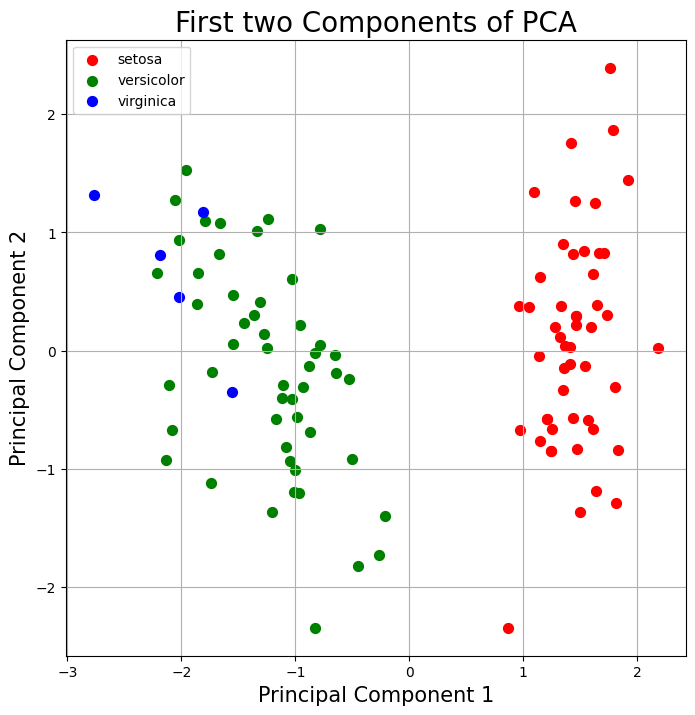

In [22]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('First two Components of PCA', fontsize = 20)

targets = [0, 1, 2]
names = ['setosa', 'versicolor','virginica']
colors = ['r', 'g', 'b'] 
for target, color, name in zip(targets, colors, names):
    indicesToKeep = y == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(names)
ax.grid()

Based on what is observed in the graph of the first 2 principal components, we notice how the setosa species differentiates from the versicolor and virginica species in principal component 1, which is attributed to the variables petal length (cm), and sepal length (cm).

Among its other applications, here we were able to use PCA to describe a dataset in a dimension smaller than that of the original dataset. As previously discussed, we noticed how we can describe interesting aspects of the original data without the need to address separately all the dimensions of such data.

## <span style='color:Black'> **Convert your model to Cairo**  </span>

### <span style='color:Black'> **Generating Cairo files**  </span>

Now let's generate Cairo files for each tensor in the object.

In [23]:
def decimal_to_fp16x16(num):

    whole_num = int(num)
    fractional_part = int((num - whole_num) * 65536)
    fp_number = (whole_num << 16) + fractional_part
    return fp_number

In [24]:
import os

In [25]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
new_directory_path = os.path.join(parent_directory, "src/generated")

In [26]:
os.makedirs('src/generated', exist_ok=True) 

In [27]:
tensor_name = ["X","X_std","y"]

def generate_cairo_files(data, name):

    with open(os.path.join('src', 'generated', f"{name}.cairo"), "w") as f:
        f.write(
            "use array::{ArrayTrait, SpanTrait};\n" +
            "use orion::operators::tensor::{core::{Tensor, TensorTrait}};\n" +
            "use orion::operators::tensor::FP16x16Tensor;\n" +
            "use orion::numbers::fixed_point::implementations::fp16x16::core::{FP16x16, FixedTrait};\n" +
            "\n" + f"fn {name}() -> Tensor<FP16x16>" + "{\n\n" + 
            "let mut shape = ArrayTrait::new();\n"
        )
        for dim in data.shape:
            f.write(f"shape.append({dim});\n")
    
        f.write("let mut data = ArrayTrait::new();\n")
        for val in np.nditer(data.flatten()):
            f.write(f"data.append(FixedTrait::new({abs(int(decimal_to_fp16x16(val)))}, {str(val < 0).lower()}));\n")
        f.write(
            "let tensor = TensorTrait::<FP16x16>::new(shape.span(), data.span());\n" +
            "return tensor;\n}"
        )

with open(f"src/generated.cairo", "w") as f:
    for n in tensor_name:
        f.write(f"mod {n};\n")

generate_cairo_files(X, "X")
generate_cairo_files(X_std, "X_std")
generate_cairo_files(y, "y")

<span style='color:Black'> **Convert some hyperparameters to FP16x16**  </span>

In [28]:
tol=1e-2
max_iter=500

In [29]:
print(decimal_to_fp16x16(tol))
print(decimal_to_fp16x16(max_iter))

655
32768000


<span style='color:Black'> **Get an estimate for the first two values of eigenvalus and first eigenvector in FP16x16**  </span>

In [30]:
evec_1 = np.array([decimal_to_fp16x16(evec[0][0]),
              decimal_to_fp16x16(evec[0][1]),
              decimal_to_fp16x16(evec[0][2])])

print("First Eigenvalue: {}".format(decimal_to_fp16x16(evalu[0])))
print("Second Eigenvalue: {}".format(decimal_to_fp16x16(evalu[1])))

print("First Eigenvector: {}".format(evec_1))

First Eigenvalue: 137983
Second Eigenvalue: 53087
First Eigenvector: [-38469  36581 -38429]


For the implementation of PCA in Cairo with Orion, please visit the Convert your model section within the **Verifiable Principal Componentes Analysis tutorial**